## Visualizing Original Geoparser - Total

We have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) with the original language model for finding the Name Entities for all Scottish Gazetteers, and select just the ones regarding with places. Later, once we have the locations entities, we have used the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('../../../results_Gazetteer/results_with_bb/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [26]:
def plot_bar_places(df_group_places, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['Place']))
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['Place'], rotation=80, fontsize=12)
    plt.xticks(index, place_label, rotation=80, fontsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    if plot_type == "resolved":
        plt.bar(index, df_group_places['count'], color='orange')
        plt.title('15 Places most mentioned using the Original Geoparser across all Scottitsh Gazetteer')
    else:
        plt.bar(index, df_group_places['count'], color='coral')
        plt.title('15 Places most mentioned but not resolved using Original Geoparser across all Scottitsh Gazetteer')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: geoparser_original
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [7]:
results=read_query_results('geoparser_original_total')

In [59]:
df_total= geresolution_dataframe(results)

year 1842
year 1901
year 1868
year 1838
year 1803
year 1806
year 1846
year 1828
year 1848
year 1883
year 1882
year 1825


In [60]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,SCOTLAND,Page3,1842
1,33.64836,-98.46944999999999,Scotland,Page6,1842
2,57.1333333,-2.1,ABERDEEN,Page7,1842
3,43.892223,-69.938614,BRUNSWICK,Page7,1842
4,51.64875,-0.0974,LONDON,Page7,1842


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [61]:
df_total[["Place"]].count()

Place    556213
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [74]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [75]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     65218
Longitude    65218
Place        65218
Page         65218
Year         65218
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [76]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     490995
Longitude    490995
Place        490995
Page         490995
Year         490995
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [77]:
df_resolved = df_total[df_total['Latitude'] != '']

In [78]:
df_resolved.count()

Latitude     490995
Longitude    490995
Place        490995
Page         490995
Year         490995
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [79]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [80]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,Scotland,Page3,1842
1,33.64836,-98.46944999999999,Scotland,Page6,1842
2,57.1333333,-2.1,Aberdeen,Page7,1842
3,43.892223,-69.938614,Brunswick,Page7,1842
4,51.64875,-0.0974,London,Page7,1842
5,56,-4,Scotland,Page7,1842
6,55.95,-3.3725,Edinburgh,Page7,1842
7,55.8666667,-4.25,Queen street,Page7,1842
8,55.073,-3.604,Dumfries,Page7,1842
9,56.4525,-3.02583,Dundee,Page7,1842


In [81]:
df_max_geolocations = df_capitalized[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


print(df_max_geolocations.count())
df_max_geolocations.head(15)


Latitude     21659
Longitude    21659
count        21659
dtype: int64


,Latitude,Longitude,count
17019,56,-4,6909
16572,55.8666667,-4.25,5037
16865,55.95,-3.3725,4769
17912,56.5,-4,4551
17706,56.39153,-3.43951,4151
16856,55.9497284685701,-3.19333076477051,3146
18920,57.1666667,-2.6666667,2949
16863,55.95,-3.2,2537
16610,55.87194,-4.43306,2537
17246,56.1166667,-3.95,2533


In [70]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=[]
place_label, place_freq = label_freq_places(df_capitalized, df_max_geolocations, filter_list)
    

0 6909 Scotland
1 5037 Queen street
2 4769 Edinburgh
3 4551 Perthshire
4 4151 Scotland
5 3146 Edinburgh
6 2949 Aberdeenshire
7 2537 Edinburgh
8 2537 Glasgow
9 2533 Stirling
10 2501 Tay
11 2456 Stirlingshire
12 2436 Galloway
13 2290 Aberdeen
14 2214 Forfarshire
15 2184 Inverness
16 2095 Leith
17 2038 Perth


In [71]:
#Visualizing the 15 places in a Bar plot
df_places = {'Place':place_label,'Place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,Place,count
11,Scotland,11060
2,Edinburgh,10452
10,Queen street,5037
9,Perthshire,4551
1,Aberdeenshire,2949
5,Glasgow,2537
12,Stirling,2533
14,Tay,2501
13,Stirlingshire,2456
4,Galloway,2436


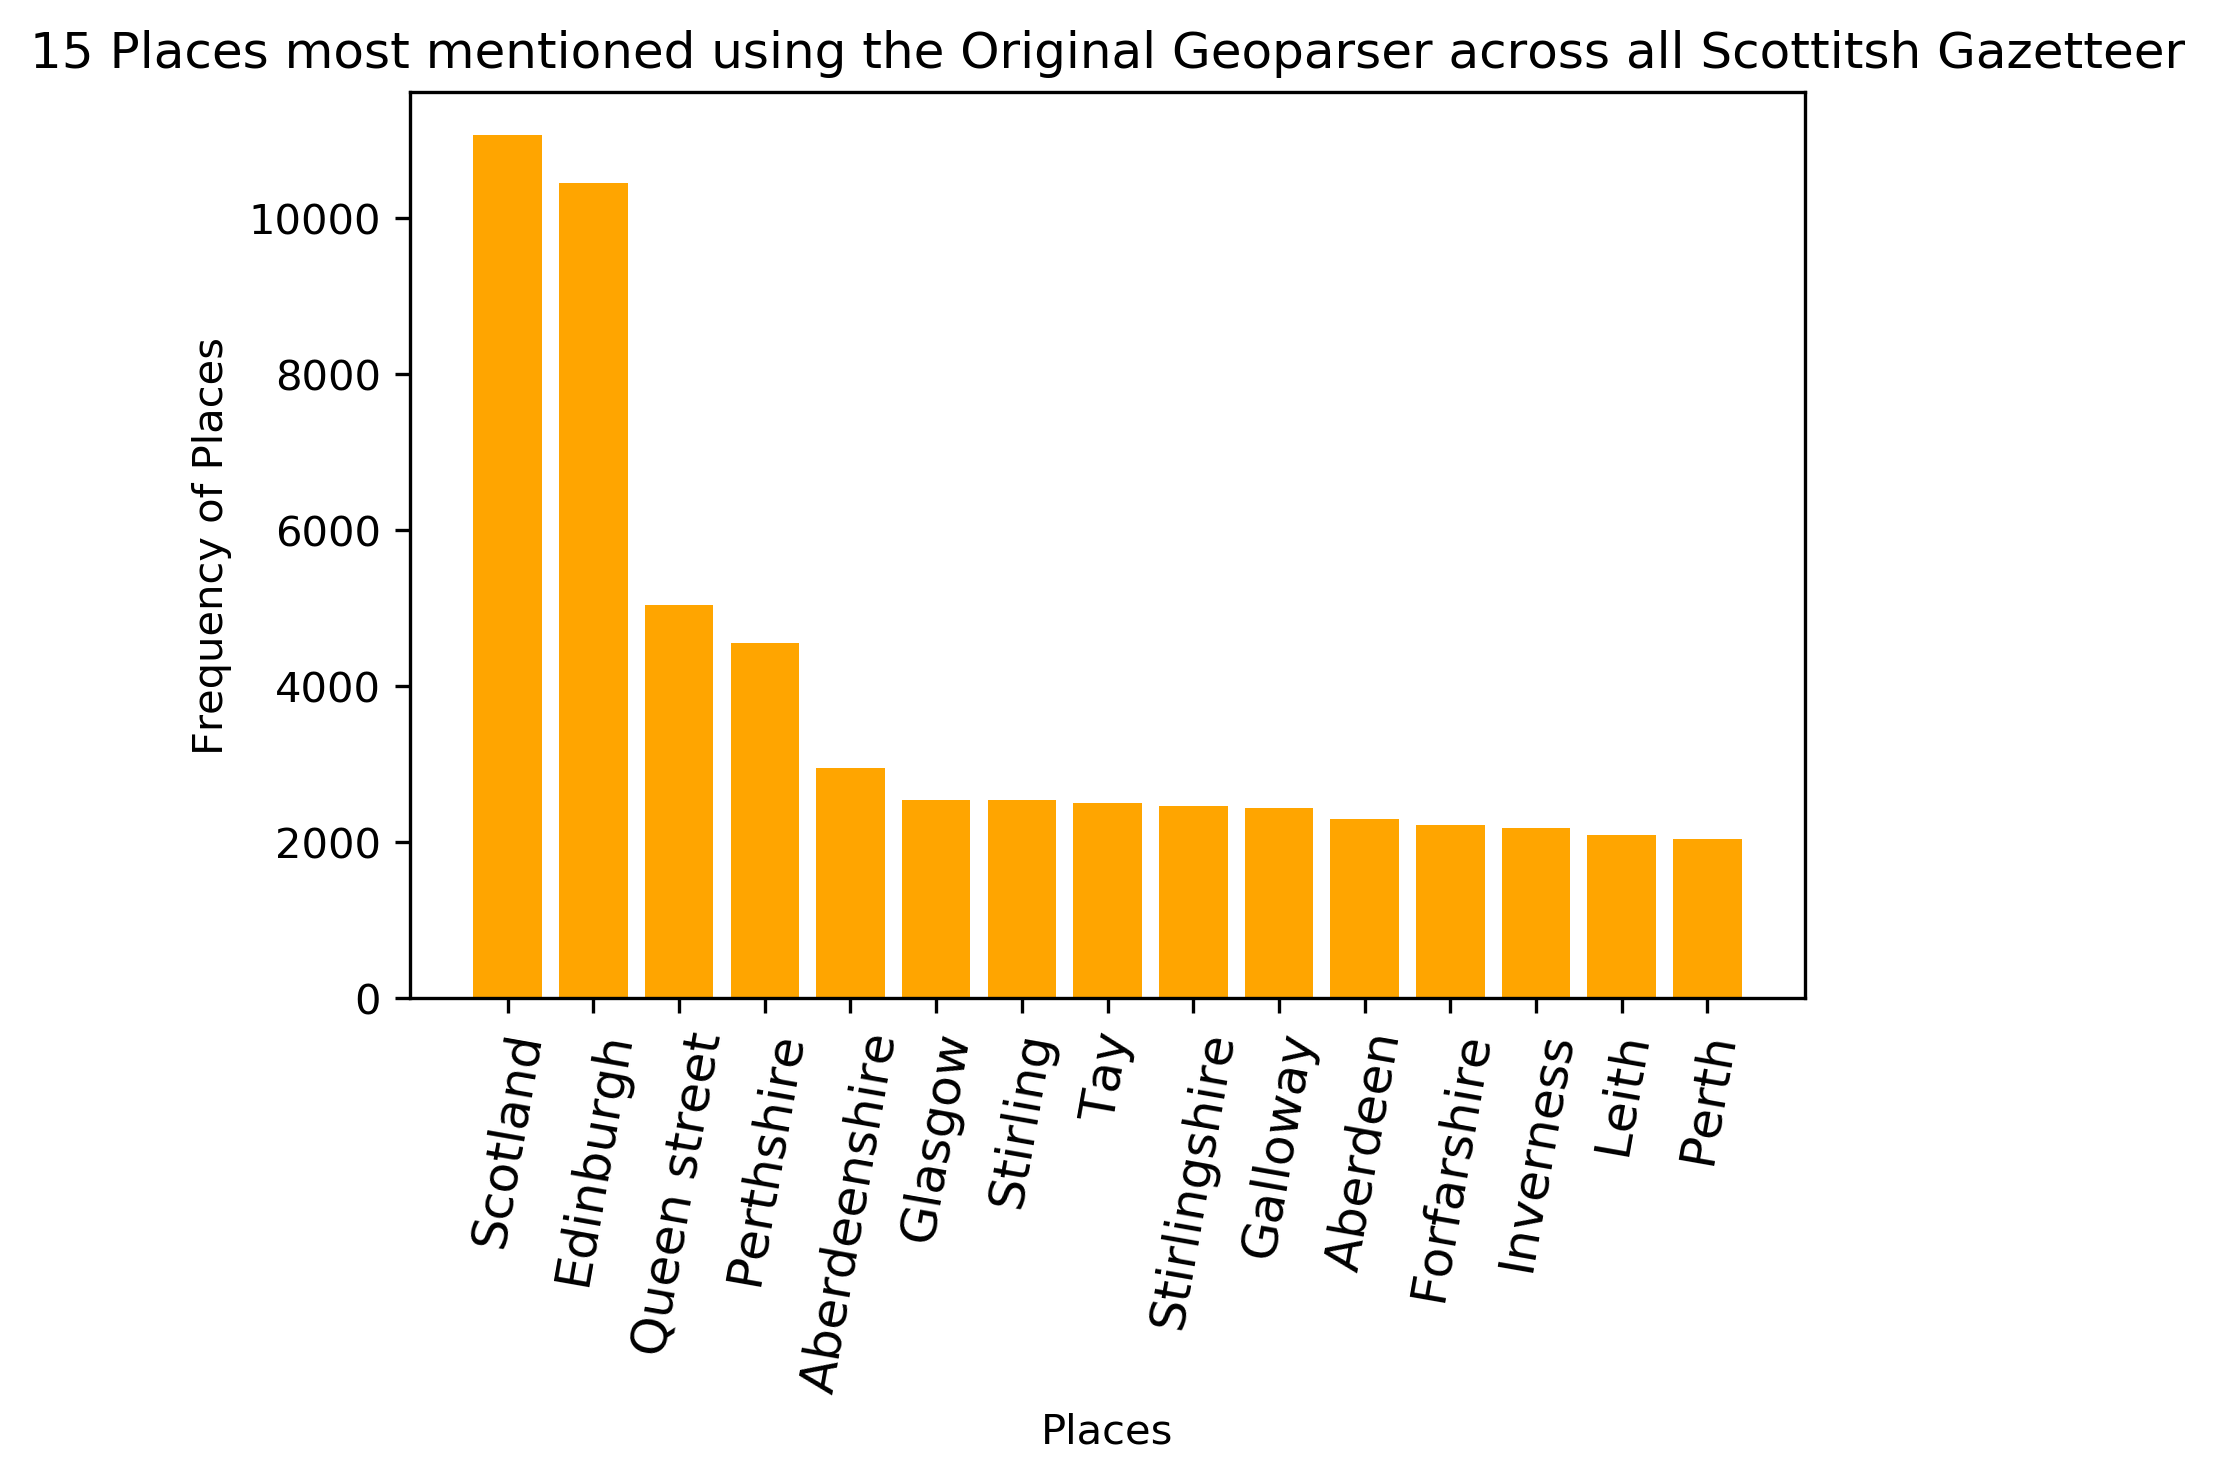

In [72]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places, plot_type='resolved')

## Exploring the locations not resolved

Places names - forcing all to lower case, and later capitalize them

In [73]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [41]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)


In [42]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
#displapying the first 15 rows
df_not_resolved_max.head(15)

Place    15943
count    15943
dtype: int64


,Place,count
5432,Edinburghshire,1416
6883,Haddingtonshire,938
427,Argyleshire,851
8672,Linlithgowshire,717
15276,Tyne,456
6332,German ocean,350
3591,Cowgate,224
3999,Culdees,213
7545,Inverury,210
14075,Shotts,202


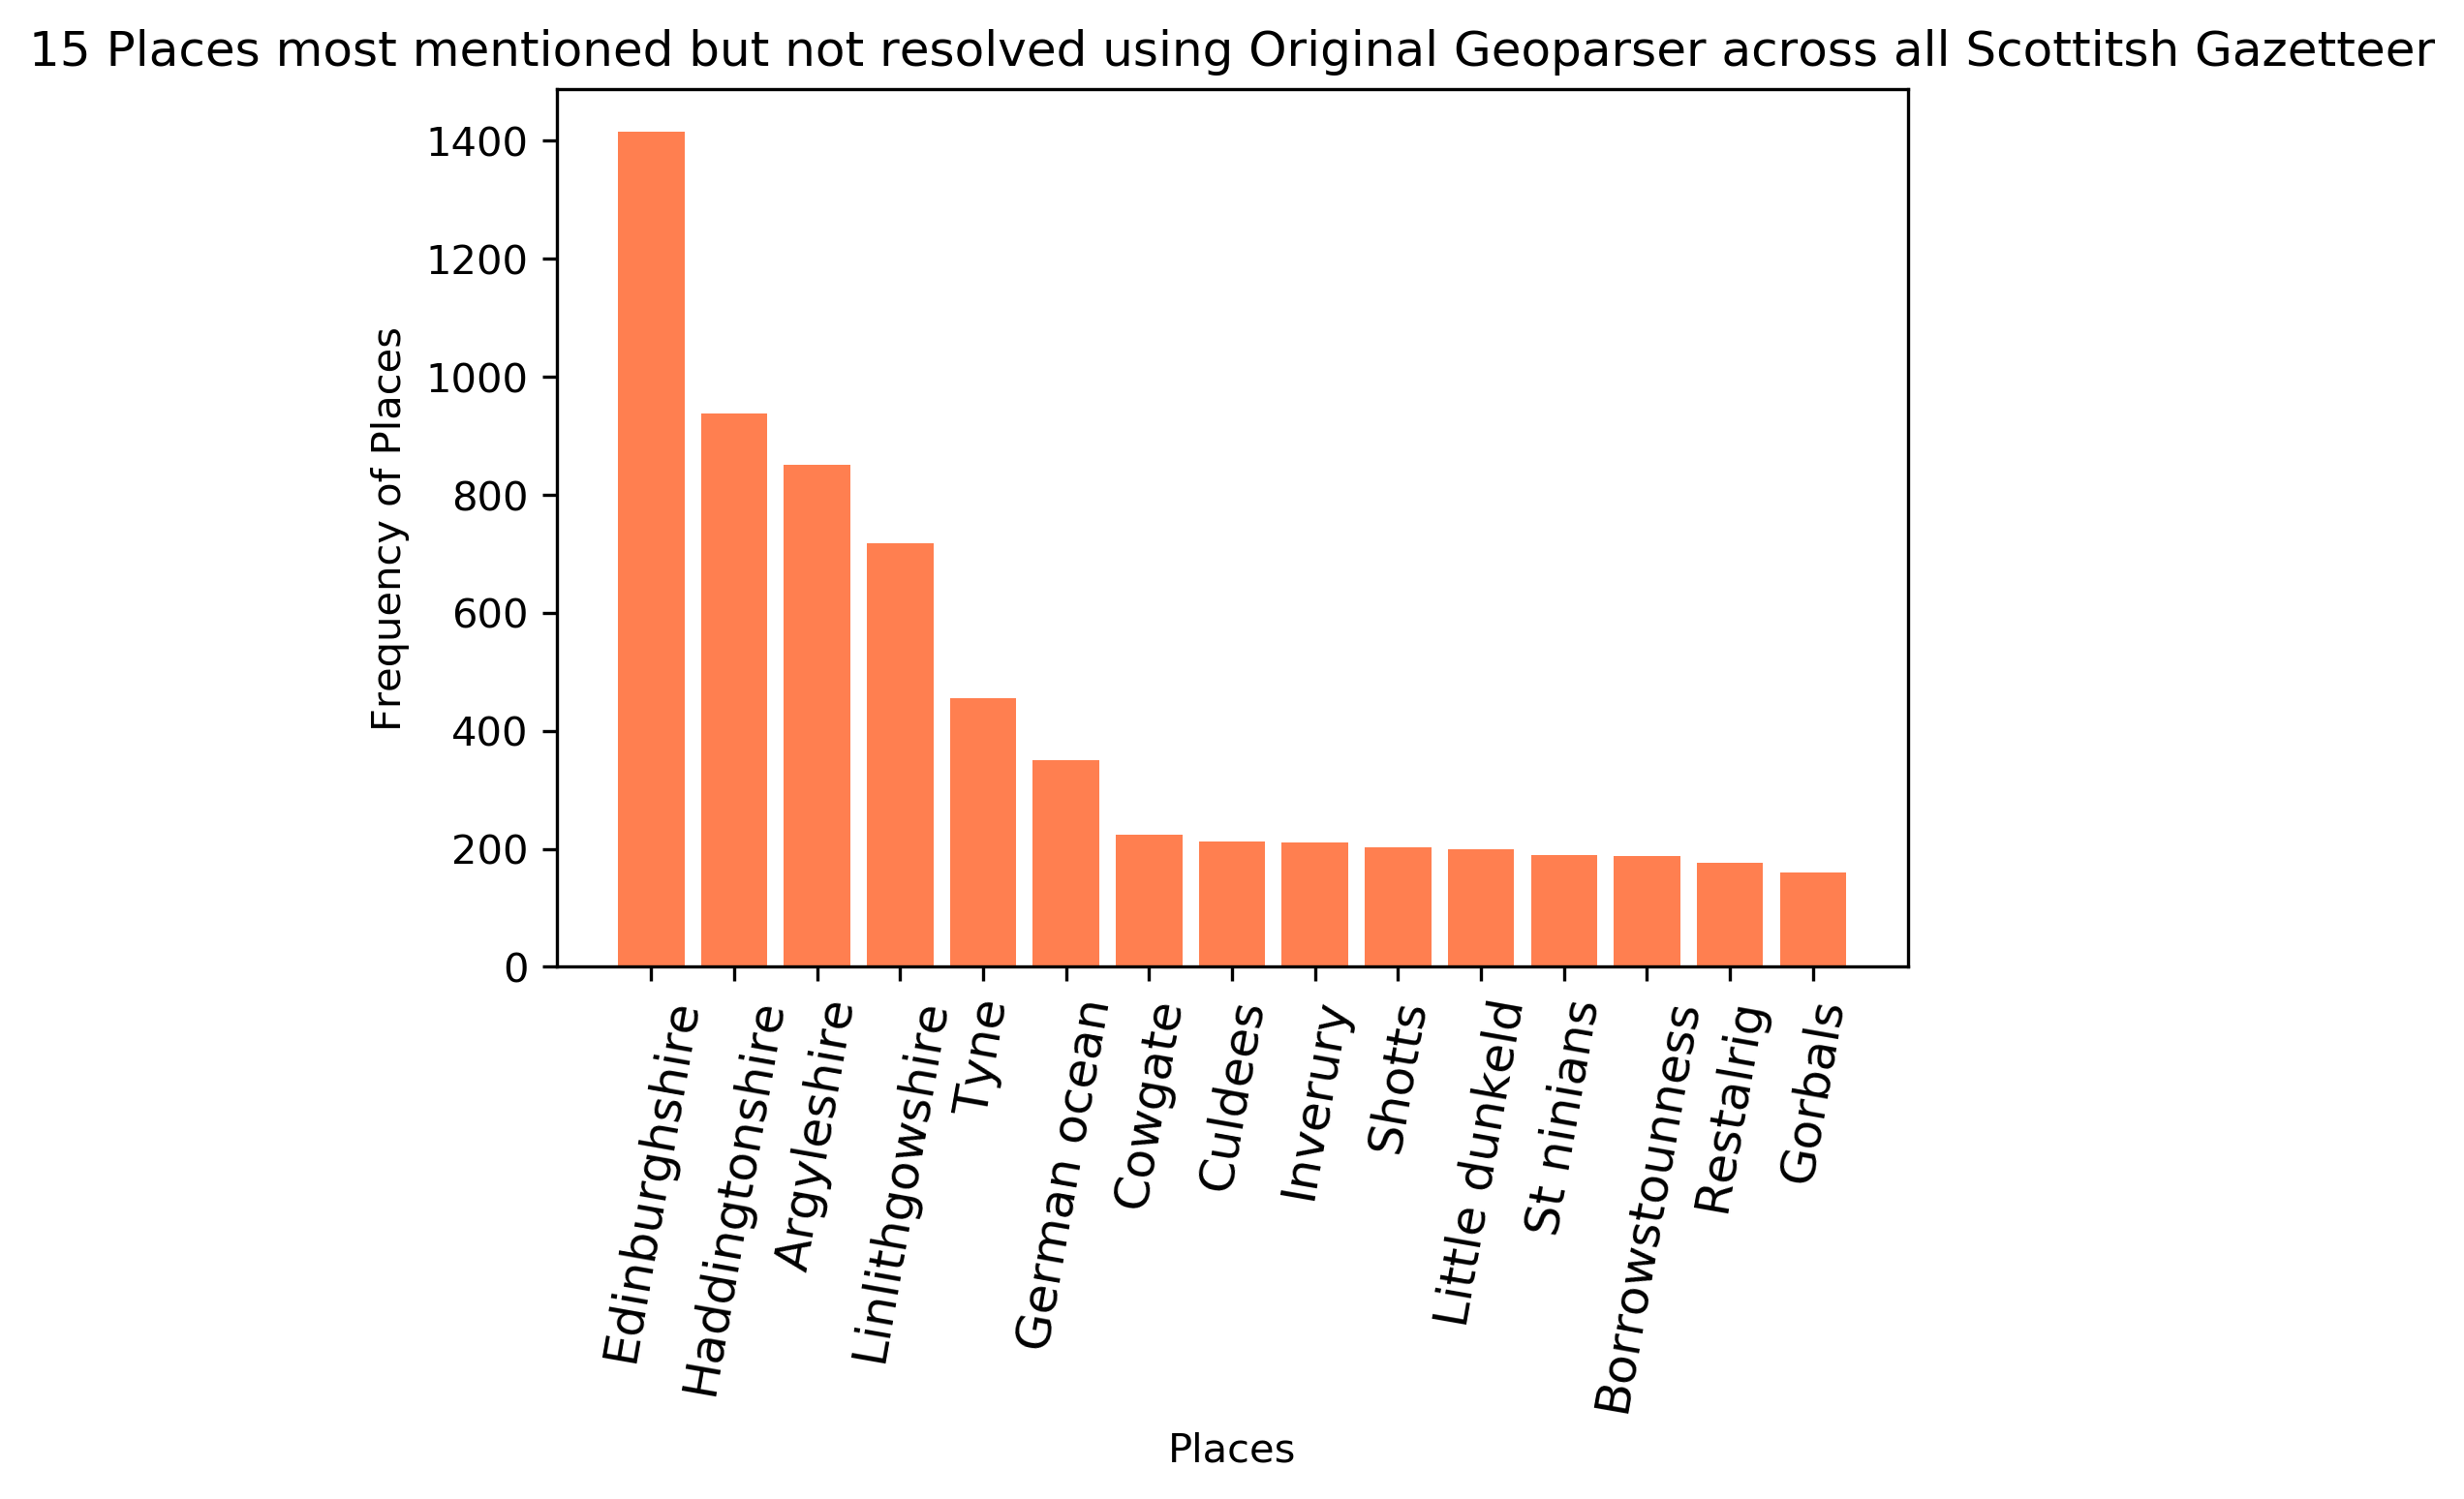

In [28]:
df_not_resolved_15 = df_not_resolved_max.head(15)
plot_bar_places(df_not_resolved_15, plot_type="not_resolved")